# Multiscale textures

In [1]:
%run init_notebook.py
% matplotlib inline

from ia_mri_tools.coil_correction import coil_correction_glasser
from ia_mri_tools.features import textures

In [2]:
# Load the data
t1 = load_data('T1')
t2 = load_data('T2')

# Correct for the coil inhomogeneity
c = coil_correction_glasser(t1,t2)
ct1 = c*t1
ct2 = c*t2

# and compute the textures at 4 different scales
scales = [1, 2, 4, 8]

t1_textures, t1_labels = textures(ct1, scales, 't1')
t2_textures, t2_labels = textures(ct2, scales, 't2')

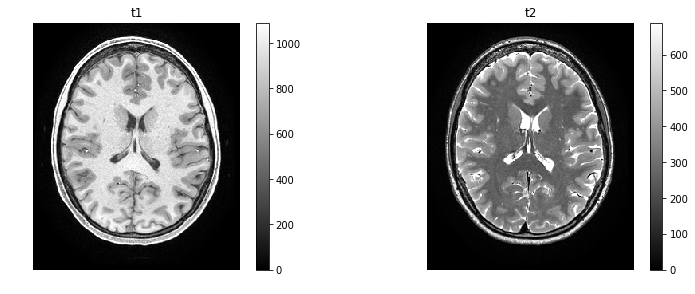

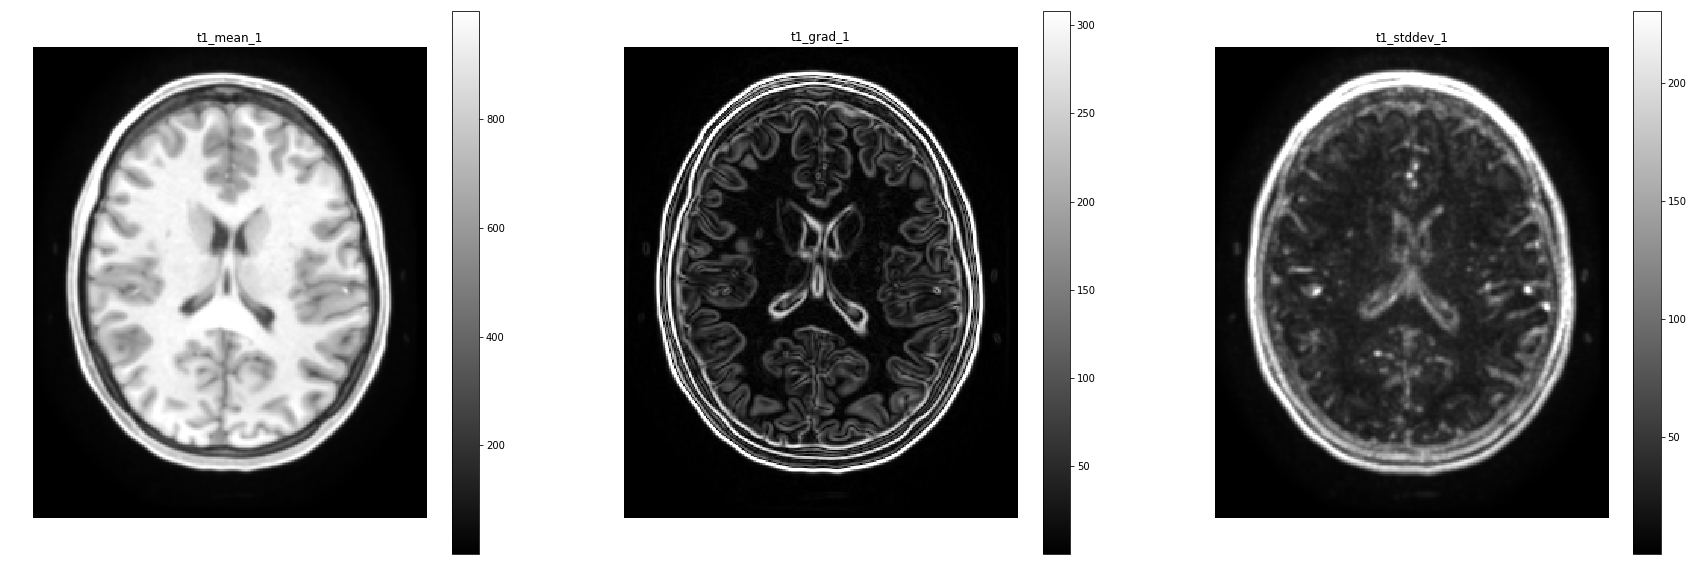

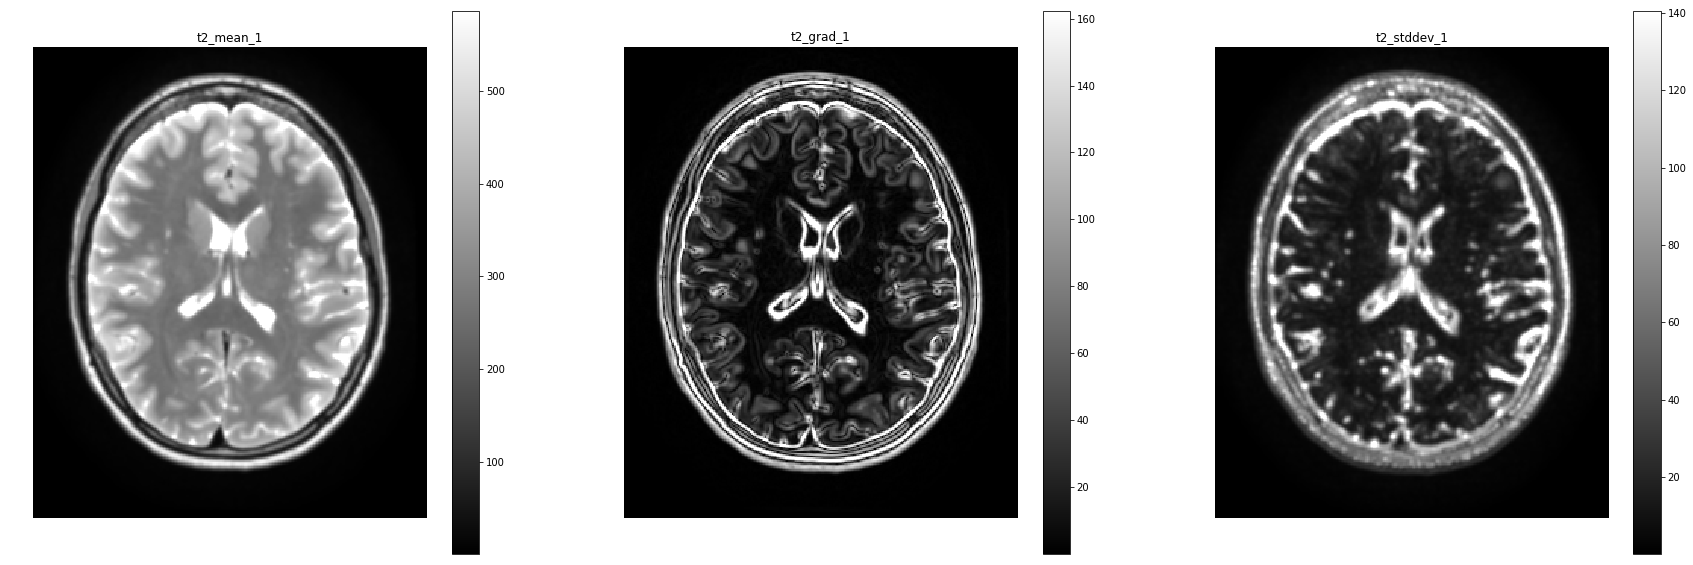

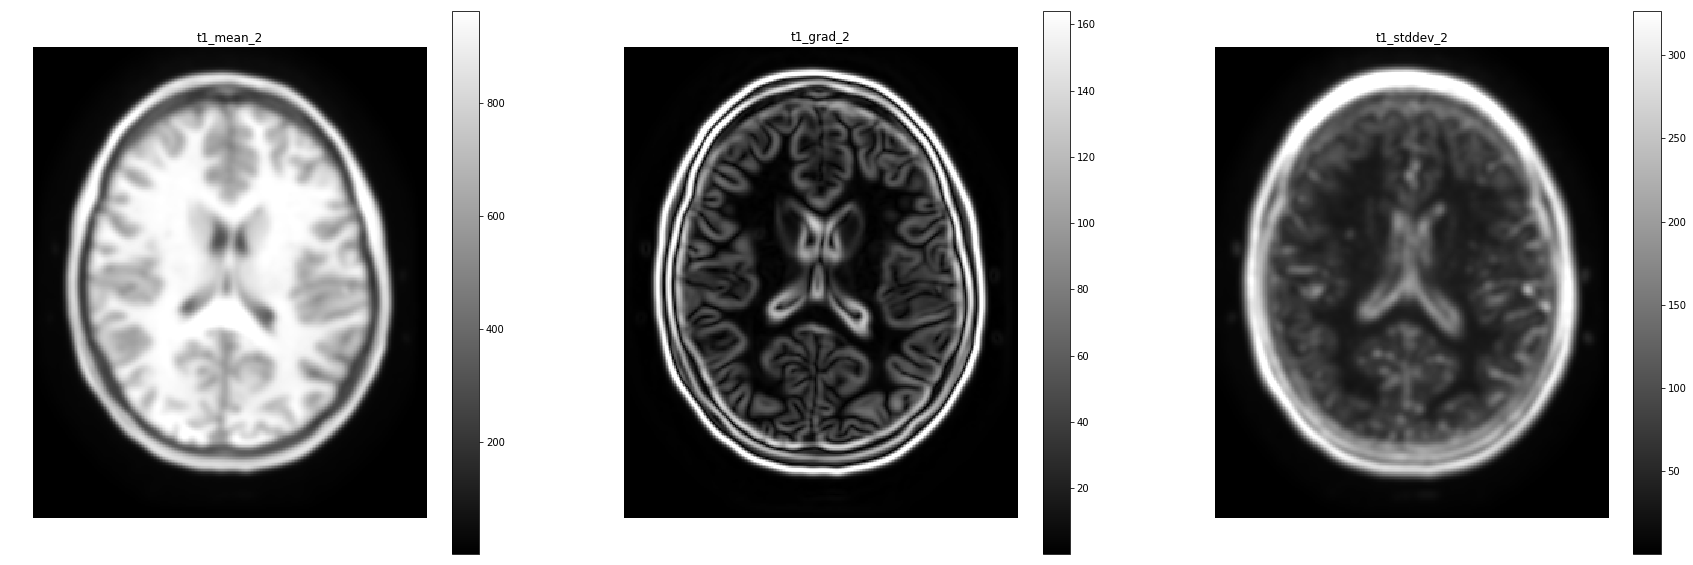

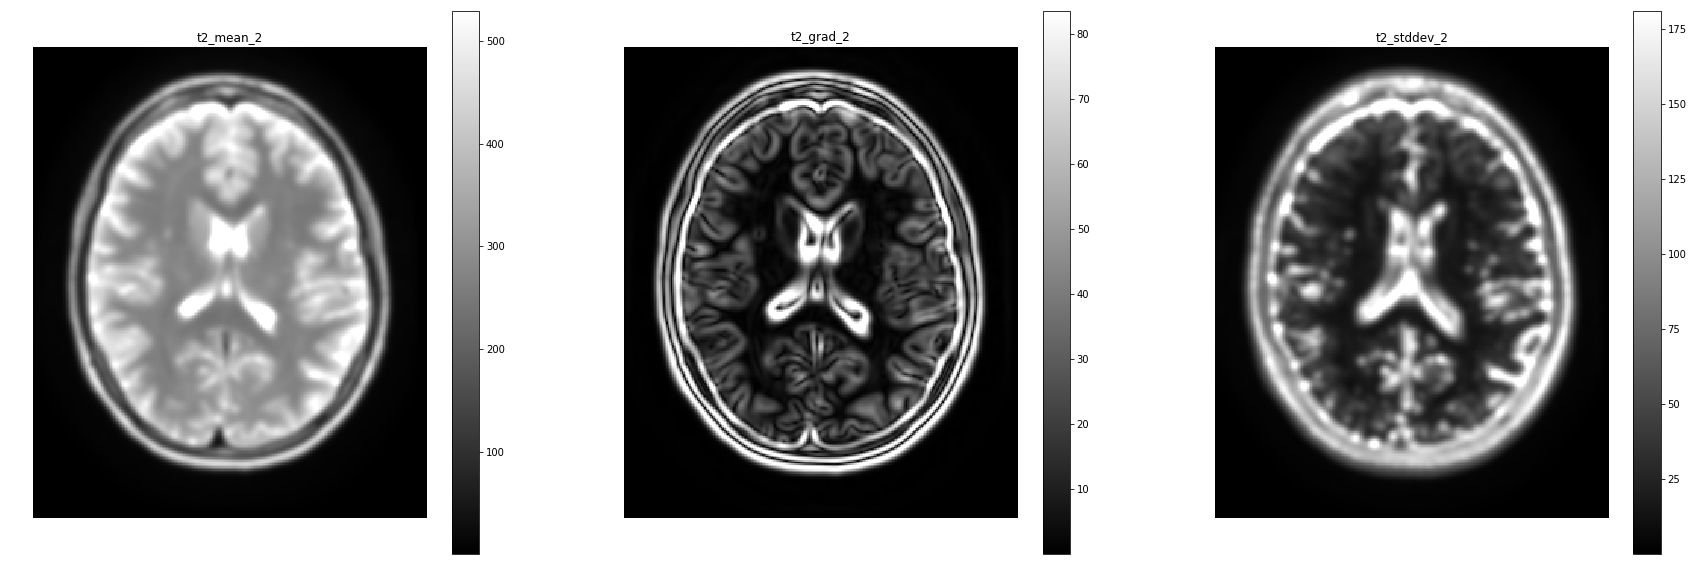

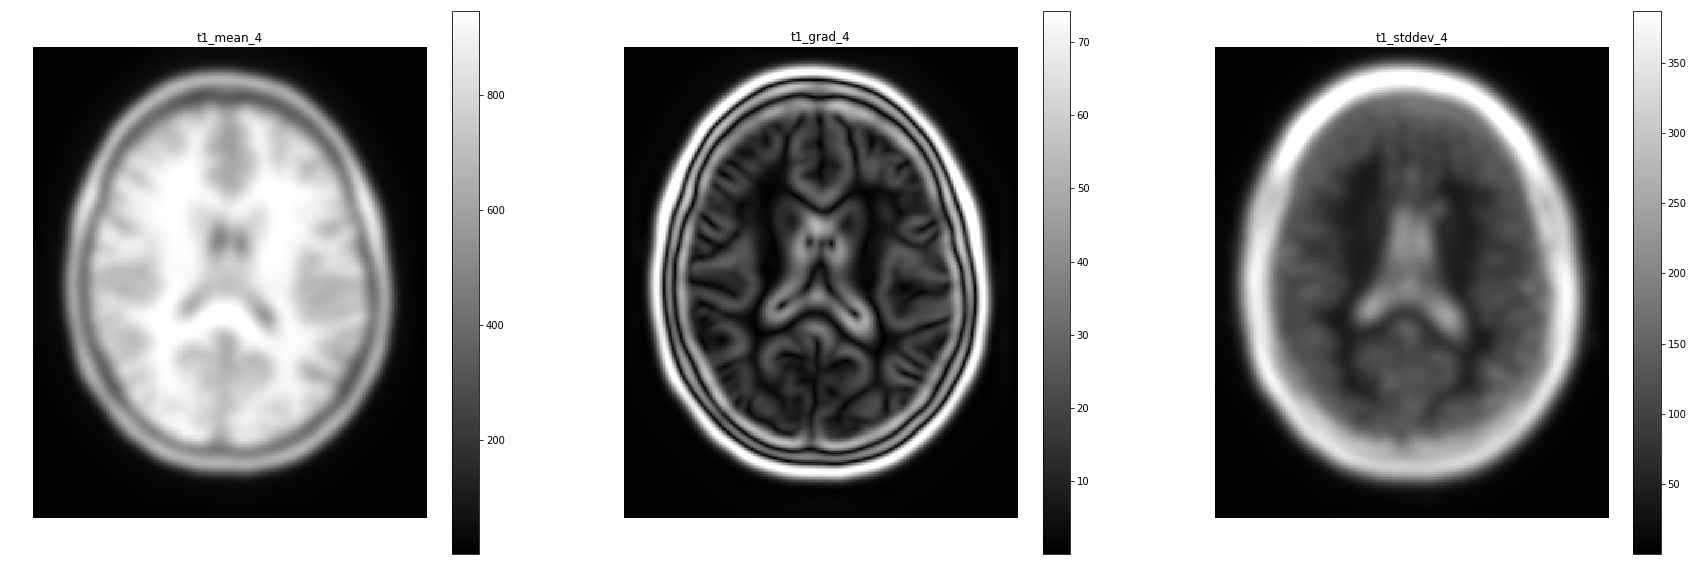

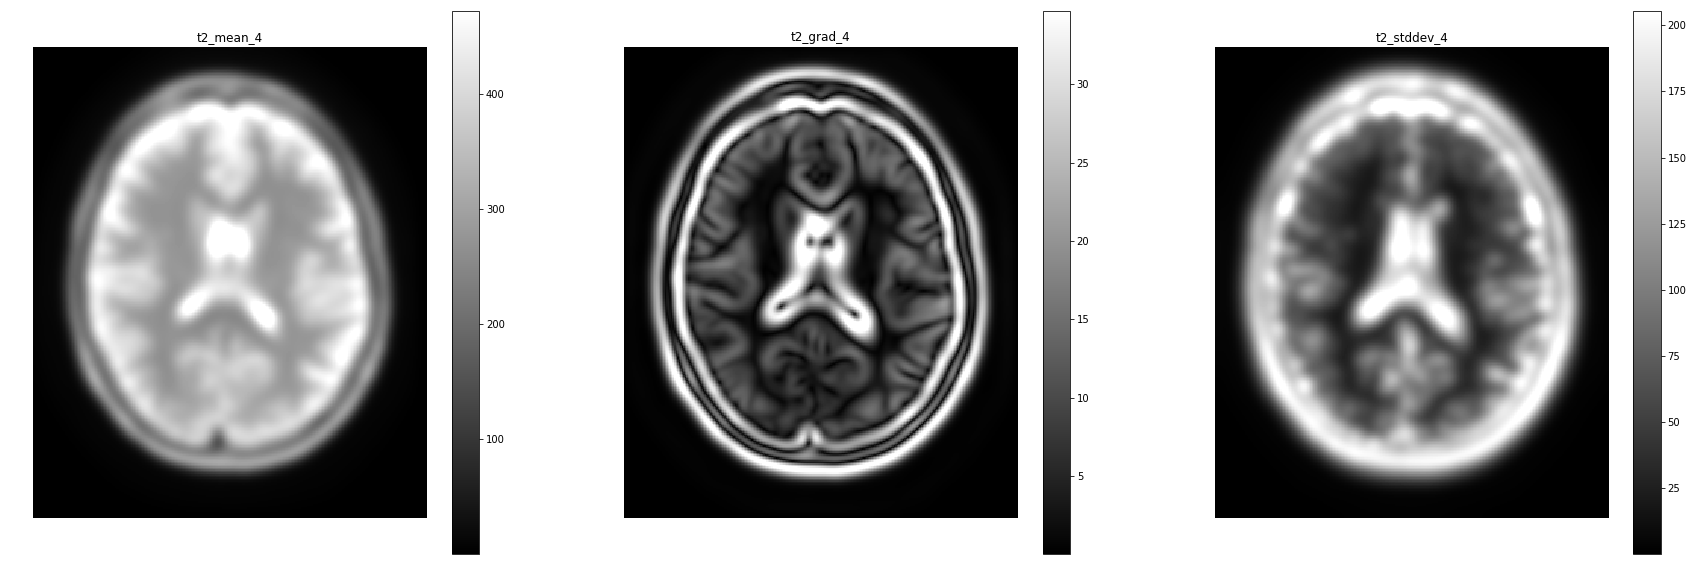

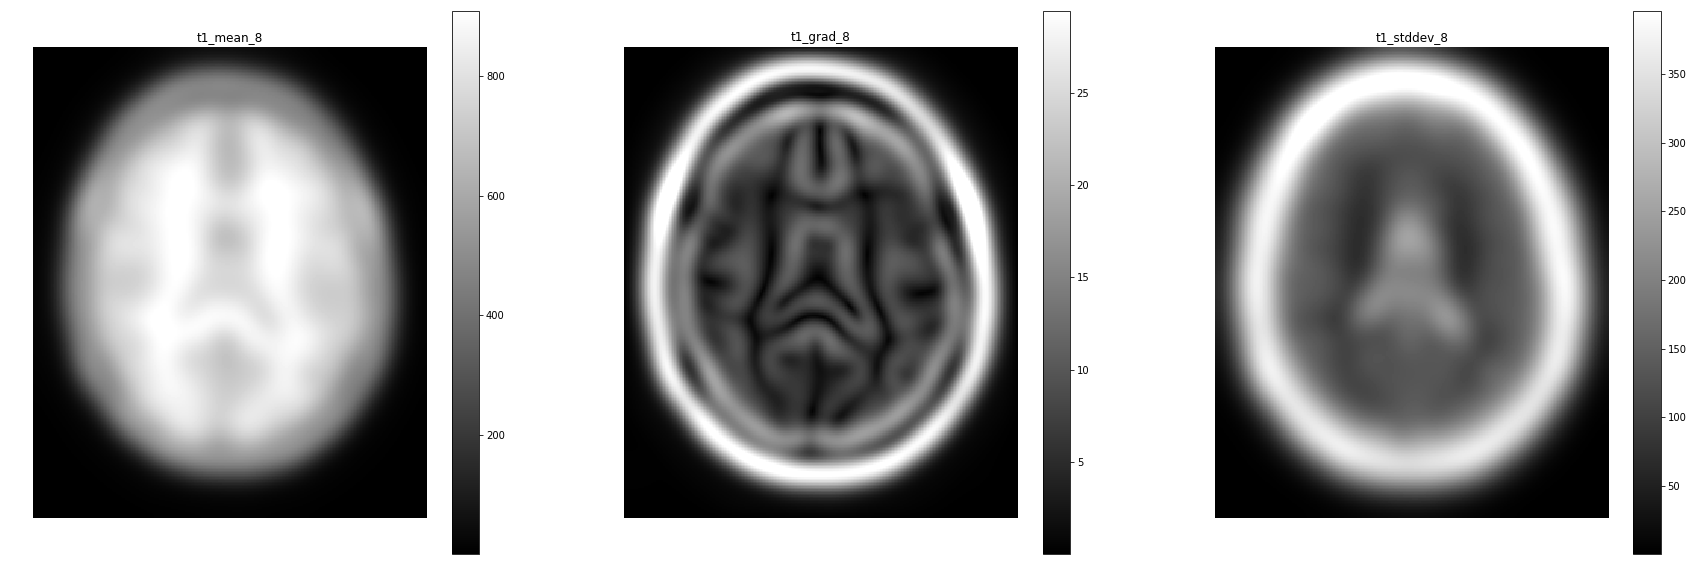

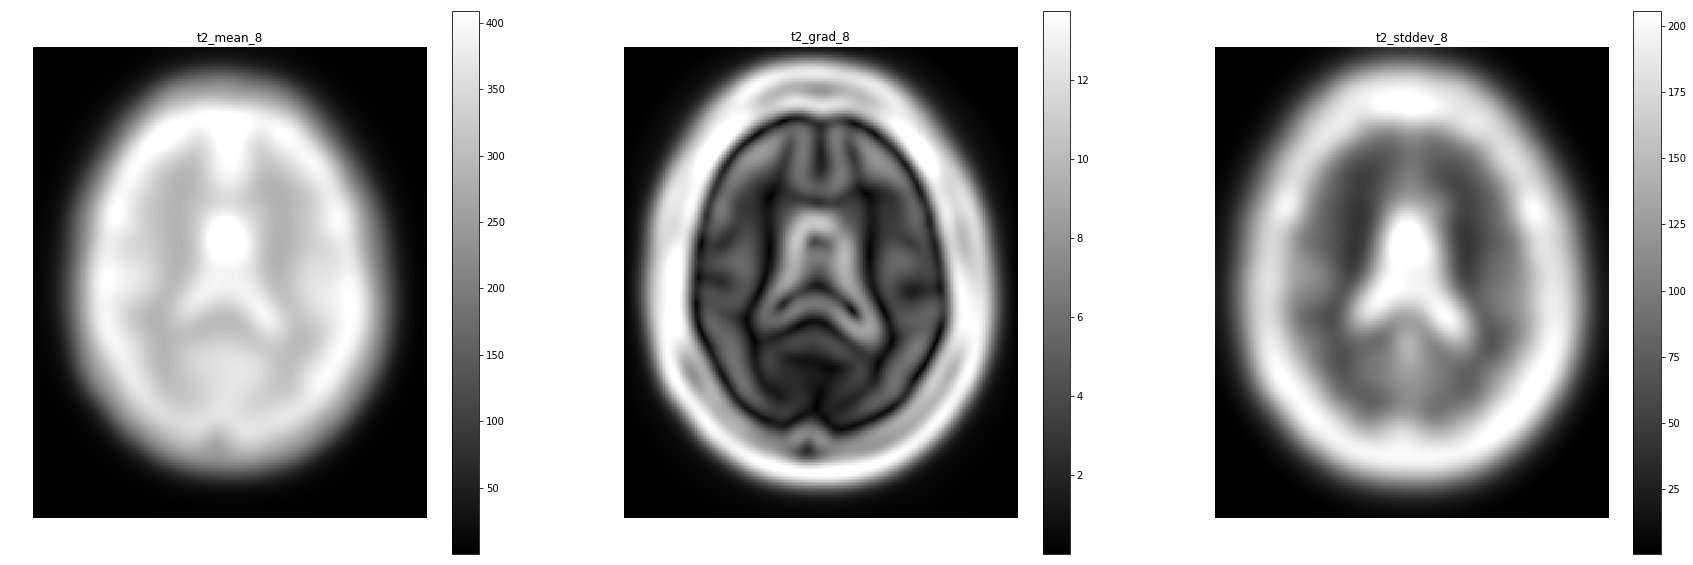

In [3]:
# Display for only one slice
z = 120

plt.figure(figsize=[20,10])
im_show(t1_textures[:,:,z,0], 2,3,1, t1_labels[0])
im_show(t2_textures[:,:,z,0], 2,3,2, t2_labels[0])

for s in range(len(scales)):
    plt.figure(figsize=[30, 10])
    for n in range(1,4):
        im_show(t1_textures[:,:,z,3*s+n], 1,3,n, t1_labels[3*s+n])
    plt.figure(figsize=[30, 10])
    for n in range(1,4):
        im_show(t2_textures[:,:,z,3*s+n], 1,3,n, t2_labels[3*s+n])

